## Ampliación FCNN: segmentación de imágenes

Sabemos que CNN tiene excelentes capacidades de extracción de características, evitando las limitaciones de la extracción manual de características, lo que también significa que CNN tiene un buen rendimiento de clasificación, lo que resuelve el problema del reconocimiento de imágenes. Gran problema ¿Una CNN tan poderosa se limita a sus funciones? Por supuesto que no. De hecho, los investigadores han extendido CNN ahora a más tareas, como la detección de objetos RCNN, YOLO, etc., la segmentación de imágenes FCN, U-Net, etc., y aún más integra el reconocimiento de detección de objetos y las tareas de segmentación de instancias en una sola.

**J. Long et al (2015)** fueron los primeros en utilizar una arquitectura basada
exclusivamente en capas convolucionales y de pooling para realizar tareas de
segmentación semántica. Este tipo de red recibe como entrada una imagen de un determinado tamaño y como salida devuelve la imagen segmentada del mismo tamaño.

<img src="https://i.ibb.co/DWzzf77/segmentacion-semantica.png" alt="ga_problem" border="0">


Es decir, en este caso, la clasificación se hace a nivel de píxel. Cada uno de los píxeles de la imagen pertenece a una determinada clase.

Los autores modifican redes conocidas como AlexNet VGG 16 o GoogleNet
eliminando el top model (destinado a clasificación) y reemplazándolo por más
bloques convolucionales produciendo pequeños mapas de características con
representaciones densas. Cuando se llega al final de la red, al último mapa se le debe aplicar un upsampling para llevarlo a las dimensiones espaciales originales de la imagen. La red es entrenada empleando una función de pérdidas a nivel de pixel (por ejemplo Dice).

Veámoslo con un ejemplo:

In [ ]:
# Fuente: 
# https://aboveintelligent.com/image-segmentation-with-neural-net-d5094d571b1e
# https://github.com/mzaradzki/neuralnets/tree/master/vgg_segmentation_keras

In [ ]:
!apt install python-pydot python-pydot-ng graphviz 
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  python-pyparsing-doc
The following NEW packages will be installed:
  python-pydot python-pydot-ng python-pyparsing
0 upgraded, 3 newly installed, 0 to remove and 43 not upgraded.
Need to get 91.5 kB of archives.
After this operation, 443 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-pyparsing all 2.2.0+dfsg1-2 [52.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydot all 1.2.3-1 [19.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydot-ng all 1.0.0-3 [19.8 kB]
Fetched 91.5 kB in 2s (59.3 kB/s)
Selecting previously unselected package python-pyparsing.
(Reading database ... 14432

In [ ]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add
from keras.utils import plot_model
from scipy.io import loadmat
from scipy.misc import imread
import matplotlib.pyplot as plt
from PIL import Image
import copy
from scipy.misc import bytescale
from scipy.io import loadmat

Using TensorFlow backend.


In [ ]:
# Function to create to a series of CONV layers followed by Max pooling layer
def convblock(cdim, nb, nfilt=3):
	L = []

	for k in range(1, nfilt + 1):
		convname = 'conv' + str(nb) + '_' + str(k)
		if False:
			# first version I tried
			L.append(ZeroPadding2D((1, 1)))
			L.append(Convolution2D(cdim, kernel_size=(3, 3), activation='relu', name=convname))
		else:
			L.append(Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname))

	L.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

	return L

In [ ]:
#Helper function to create Sequential part of the Architecture
def fcn32_blank(image_size=512):
	
  mdl = Sequential()

  # First layer is a dummy-permutation = Identity to specify input shape
  mdl.add(Permute((1, 2, 3), input_shape=(image_size, image_size, 3)))  # WARNING : axis 0 is the sample dim

  for l in convblock(64, 1, nfilt=2):
    mdl.add(l)

  for l in convblock(128, 2, nfilt=2):
    mdl.add(l)

  for l in convblock(256, 3, nfilt=3):
    mdl.add(l)

  for l in convblock(512, 4, nfilt=3):
    mdl.add(l)

  for l in convblock(512, 5, nfilt=3):
    mdl.add(l)

  mdl.add(Convolution2D(4096, kernel_size=(7, 7), padding='same', activation='relu', name='fc6'))  # WARNING border
  mdl.add(Convolution2D(4096, kernel_size=(1, 1), padding='same', activation='relu', name='fc7'))  # WARNING border
  
  # WARNING : model decapitation i.e. remove the classifier step of VGG16 (usually named fc8)

  mdl.add(Convolution2D(21, kernel_size=(1, 1), padding='same', activation='relu', name='score_fr'))

  convsize = mdl.layers[-1].output_shape[2]
  deconv_output_size = (convsize - 1) * 2 + 4  # INFO: =34 when images are 512x512
  # WARNING : valid, same or full ?
  mdl.add(Deconvolution2D(21, kernel_size=(4, 4), strides=(2, 2), padding='valid', activation=None, name='score2'))

  extra_margin = deconv_output_size - convsize * 2  # INFO: =2 when images are 512x512
  assert (extra_margin > 0)
  assert (extra_margin % 2 == 0)
  # INFO : cropping as deconv gained pixels
  # print(extra_margin)
  c = ((0, extra_margin), (0, extra_margin))
  # print(c)
  # mdl.add(Cropping2D(cropping=c))
  mdl.add(Cropping2D(cropping=((extra_margin/2, extra_margin/2), (extra_margin/2, extra_margin/2))) ) # INFO : cropping as deconv gained pixels
  # print(mdl.summary())

  return mdl

In [ ]:
def fcn_32s_to_16s(fcn32model=None):
  if fcn32model is None:
    fcn32model = fcn32_blank()

  fcn32shape = fcn32model.layers[-1].output_shape
  assert (len(fcn32shape) == 4)
  assert (fcn32shape[0] is None)  # batch axis
  assert (fcn32shape[3] == 21)  # number of filters
  assert (fcn32shape[1] == fcn32shape[2])  # must be square

  fcn32size = fcn32shape[1]  # INFO: =32 when images are 512x512

  if fcn32size != 32:
    print('WARNING : handling of image size different from 512x512 has not been tested')

  sp4 = Convolution2D(21, kernel_size=(1, 1), padding='same', activation=None, name='score_pool4')

  # INFO : to replicate MatConvNet.DAGN.Sum layer see documentation at :
  # https://keras.io/getting-started/sequential-model-guide/
  summed = add(inputs=[sp4(fcn32model.layers[14].output), fcn32model.layers[-1].output])

  # INFO :
  # final 16x16 upsampling of "summed" using deconv layer upsample_new (32, 32, 21, 21)
  # deconv setting is valid if (528-32)/16 + 1 = deconv_input_dim (= fcn32size)
  deconv_output_size = (fcn32size - 1) * 16 + 32  # INFO: =528 when images are 512x512
  upnew = Deconvolution2D(21, kernel_size=(32, 32),
              padding='valid',  # WARNING : valid, same or full ?
              strides=(16, 16),
              activation=None,
              name='upsample_new')

  extra_margin = deconv_output_size - fcn32size * 16  # INFO: =16 when images are 512x512
  assert (extra_margin > 0)
  assert (extra_margin % 2 == 0)
  # print(extra_margin)
  # INFO : cropping as deconv gained pixels
  # crop_margin = Cropping2D(cropping=((0, extra_margin), (0, extra_margin)))
  crop_margin = Cropping2D(cropping=((extra_margin/2, extra_margin/2), (extra_margin/2, extra_margin/2))) # INFO : cropping as deconv gained pixels

  return Model(fcn32model.input, crop_margin(upnew(summed)))

In [ ]:
def prediction(kmodel, crpimg, transform=False):
	# INFO : crpimg should be a cropped image of the right dimension

	# transform=True seems more robust but I think the RGB channels are not in right order

	imarr = np.array(crpimg).astype(np.float32)

	if transform:
		imarr[:, :, 0] -= 129.1863
		imarr[:, :, 1] -= 104.7624
		imarr[:, :, 2] -= 93.5940
		#
		# WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
		aux = copy.copy(imarr)
		imarr[:, :, 0] = aux[:, :, 2]
		imarr[:, :, 2] = aux[:, :, 0]

	# imarr[:,:,0] -= 129.1863
	# imarr[:,:,1] -= 104.7624
	# imarr[:,:,2] -= 93.5940

	# imarr = imarr.transpose((2, 0, 1))
	imarr = np.expand_dims(imarr, axis=0)

	return kmodel.predict(imarr)

In [ ]:
fcn32model = fcn32_blank()
print(fcn32model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)    

In [ ]:
fcn16model = fcn_32s_to_16s(fcn32model)
print(fcn16model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 512, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 512, 512, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 512, 512, 64) 36928       conv1_1[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


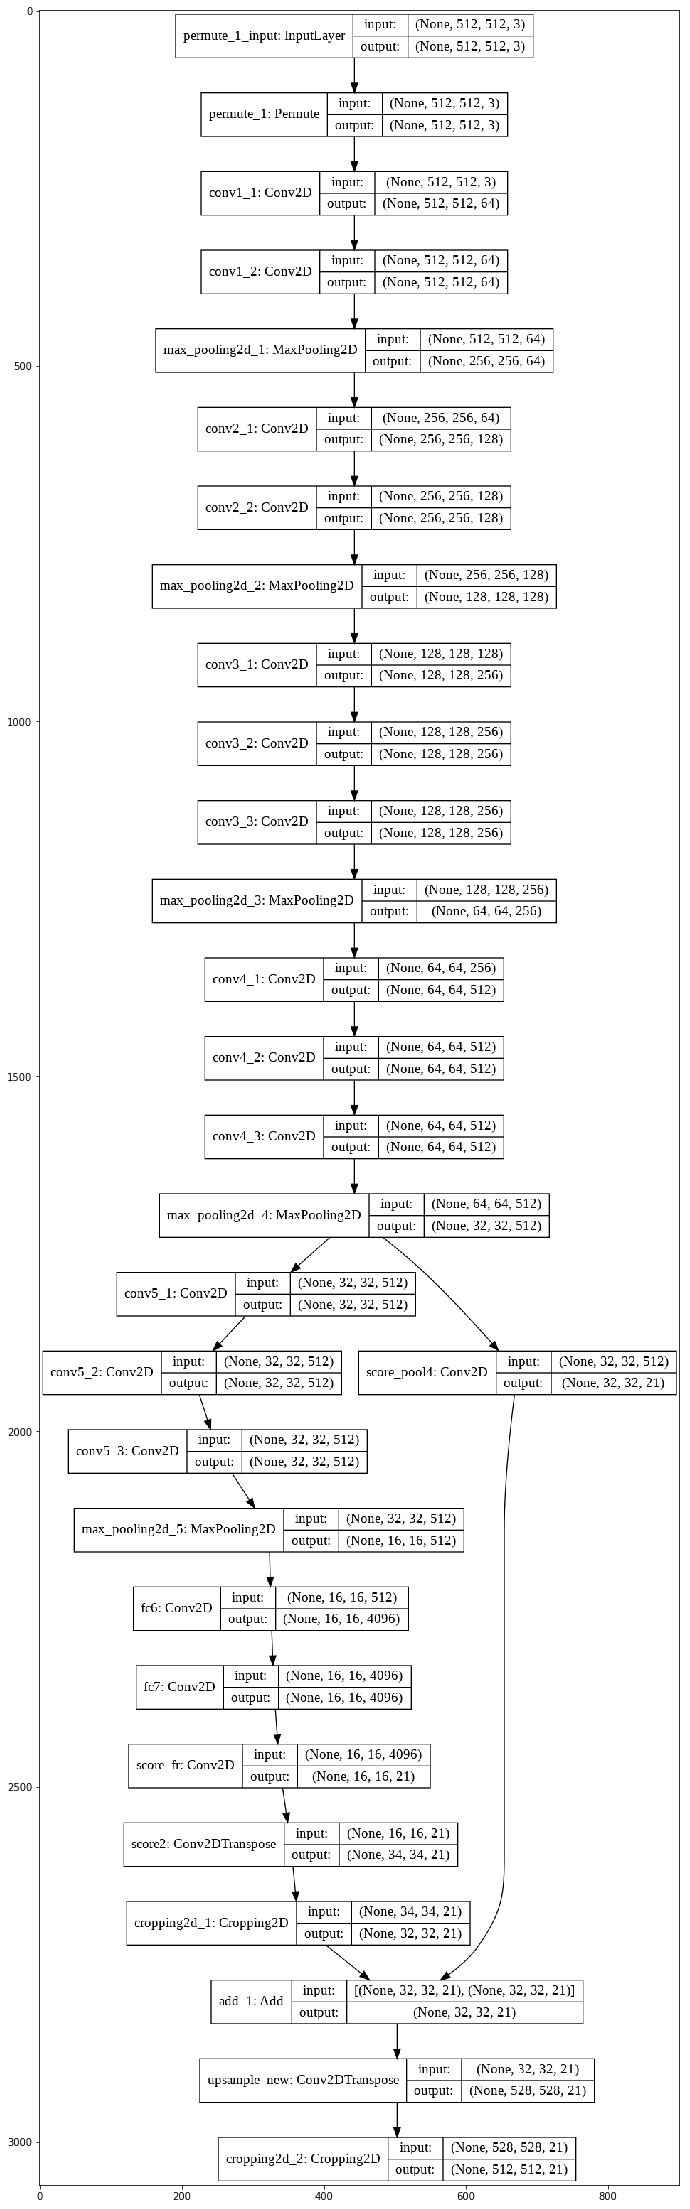

In [ ]:
plot_model(fcn16model,'FCN-16_withshape.png',show_shapes=True)
plt.figure(figsize=(150,40))
plt.imshow(imread('FCN-16_withshape.png'))

In [ ]:
!wget http://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat

--2020-06-17 11:08:34--  http://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat [following]
--2020-06-17 11:08:34--  https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500215534 (477M)
Saving to: ‘pascal-fcn16s-dag.mat’

pascal-fcn16s-dag.m 100%[===================>] 477.04M  22.6MB/s    in 22s     

2020-06-17 11:08:57 (21.8 MB/s) - ‘pascal-fcn16s-dag.mat’ saved [500215534/500215534]



In [ ]:
data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

In [ ]:
print(data.keys())

['layers', 'vars', '__header__', '__globals__', 'meta', 'params', '__version__']


In [ ]:
print(type(layers))

<type 'numpy.ndarray'>


In [ ]:
print(layers.shape)

(1, 42)


In [ ]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [ ]:
for i in range(0, params.shape[1]-1, 2):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape,
          str(params[0,i+1].name[0]), params[0,i+1].value.shape)

(0, 'conv1_1_filter', (3, 3, 3, 64), 'conv1_1_bias', (64, 1))
(2, 'conv1_2_filter', (3, 3, 64, 64), 'conv1_2_bias', (64, 1))
(4, 'conv2_1_filter', (3, 3, 64, 128), 'conv2_1_bias', (128, 1))
(6, 'conv2_2_filter', (3, 3, 128, 128), 'conv2_2_bias', (128, 1))
(8, 'conv3_1_filter', (3, 3, 128, 256), 'conv3_1_bias', (256, 1))
(10, 'conv3_2_filter', (3, 3, 256, 256), 'conv3_2_bias', (256, 1))
(12, 'conv3_3_filter', (3, 3, 256, 256), 'conv3_3_bias', (256, 1))
(14, 'conv4_1_filter', (3, 3, 256, 512), 'conv4_1_bias', (512, 1))
(16, 'conv4_2_filter', (3, 3, 512, 512), 'conv4_2_bias', (512, 1))
(18, 'conv4_3_filter', (3, 3, 512, 512), 'conv4_3_bias', (512, 1))
(20, 'conv5_1_filter', (3, 3, 512, 512), 'conv5_1_bias', (512, 1))
(22, 'conv5_2_filter', (3, 3, 512, 512), 'conv5_2_bias', (512, 1))
(24, 'conv5_3_filter', (3, 3, 512, 512), 'conv5_3_bias', (512, 1))
(26, 'fc6_filter', (7, 7, 512, 4096), 'fc6_bias', (4096, 1))
(28, 'fc7_filter', (1, 1, 4096, 4096), 'fc7_bias', (4096, 1))
(30, 'score_fr_filt

In [ ]:
for i in range(layers.shape[1]):
    print(i,
          str(layers[0,i].name[0]), str(layers[0,i].type[0]),
          [str(n[0]) for n in layers[0,i].inputs[0,:]],
          [str(n[0]) for n in layers[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [ ]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, params.shape[1]-1, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [ ]:
copy_mat_to_keras(fcn16model)

('found : ', ('conv1_1', 2))
((3, 3, 3, 64), (3, 3, 3, 64))
('found : ', ('conv1_2', 3))
((3, 3, 64, 64), (3, 3, 64, 64))
('found : ', ('conv2_1', 5))
((3, 3, 64, 128), (3, 3, 64, 128))
('found : ', ('conv2_2', 6))
((3, 3, 128, 128), (3, 3, 128, 128))
('found : ', ('conv3_1', 8))
((3, 3, 128, 256), (3, 3, 128, 256))
('found : ', ('conv3_2', 9))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv3_3', 10))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv4_1', 12))
((3, 3, 256, 512), (3, 3, 256, 512))
('found : ', ('conv4_2', 13))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv4_3', 14))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_1', 16))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_2', 17))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_3', 18))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('fc6', 20))
((7, 7, 512, 4096), (7, 7, 512, 4096))
('found : ', ('fc7', 21))
((1, 1, 4096, 4096), (1, 1, 4096, 4096))
('found : ', ('

--2020-06-17 11:09:07--  http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47099 (46K) [image/jpeg]
Saving to: ‘rgb.jpg’

rgb.jpg             100%[===================>]  46.00K  91.9KB/s    in 0.5s    

2020-06-17 11:09:08 (91.9 KB/s) - ‘rgb.jpg’ saved [47099/47099]



(-0.5, 511.5, 511.5, -0.5)

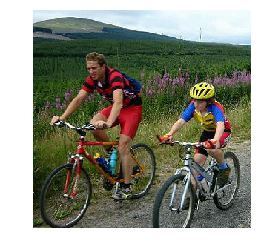

In [ ]:
!wget http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
image_size = 512
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))
plt.imshow(np.asarray(im))
plt.axis('off')

In [ ]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn16model, crpim, transform=True)

In [ ]:
preds.shape

(1, 512, 512, 21)

(-0.5, 511.5, 511.5, -0.5)

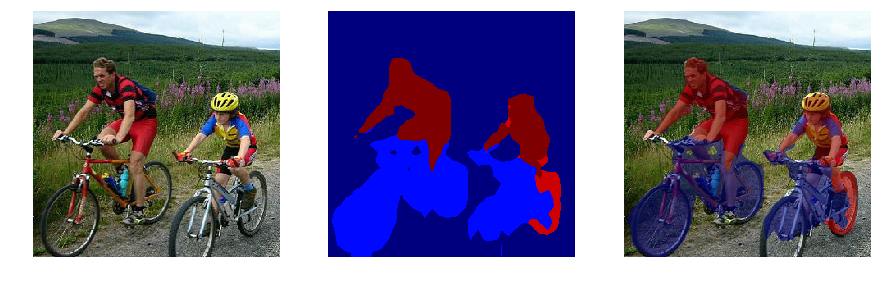

In [ ]:
imclass = np.argmax(preds, axis=3)[0,:,:]


plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(crpim)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(imclass, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(crpim)
plt.axis('off')

masked_imclass = np.ma.masked_where(imclass == 0, imclass)
plt.imshow(masked_imclass, alpha=0.5, cmap='jet')
plt.axis('off')

In [ ]:
# List of dominant classes found in the image# List o 
for c in np.unique(imclass):
    print c, str(description[0,c][0])

0 background
2 bicycle
14 motorbike
15 person


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  """Entry point for launching an IPython kernel.


(-0.5, 511.5, 511.5, -0.5)

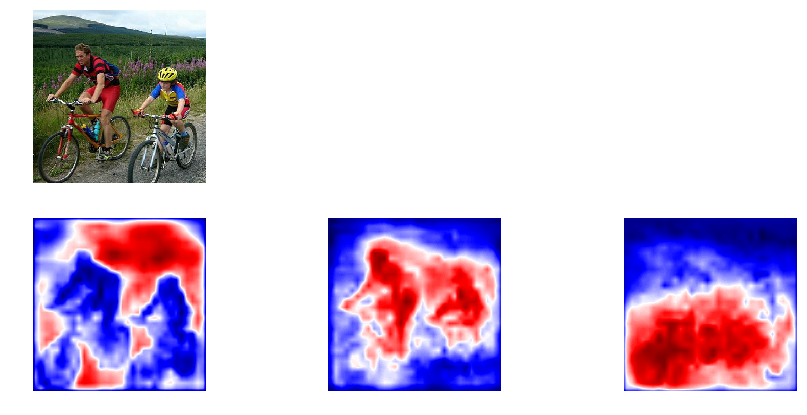

In [ ]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))

plt.subplot(2,3,1)
plt.imshow(np.asarray(crpim))
plt.axis('off')

plt.subplot(2,3,3+1)
plt.imshow(bspreds[0,:,:,class2index['background']], cmap='seismic')
plt.axis('off')

plt.subplot(2,3,3+2)
plt.imshow(bspreds[0,:,:,class2index['person']], cmap='seismic')
plt.axis('off')

plt.subplot(2,3,3+3)
plt.imshow(bspreds[0,:,:,class2index['bicycle']], cmap='seismic')
plt.axis('off')